In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
np.random.seed(42)

In [5]:
# Define categories and paths
categories = {'organic': 'biological', 'metal': 'metal', 'plastic': 'plastic'}
data_dir = './garbage-dataset/'  # Update if different
img_size = (224, 224)  # Standard size for CNNs like MobileNet

images = []
labels = []

for label, folder in categories.items():
    folder_path = os.path.join(data_dir, folder)
    if not os.path.exists(folder_path):
        raise ValueError(f"Folder not found: {folder_path}. Ensure dataset is downloaded.")
    
    for img_name in os.listdir(folder_path)[:150]:  # Limit to 150 per category for speed
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(list(categories.keys()).index(label))  # 0: organic, 1: metal, 2: plastic

images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images across {len(categories)} categories.")

Loaded 450 images across 3 categories.


In [6]:
# Task 3: Preprocess Data
# Normalize images and split into train/test. Enhanced augmentation for generalization (outcome 3).
images = images / 255.0  # Normalize to [0,1] for model

# One-hot encode labels
labels_onehot = to_categorical(labels, num_classes=3)

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels_onehot, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# Enhanced data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,  # Increased from 20 for more variety
    width_shift_range=0.3,  # Increased from 0.2
    height_shift_range=0.3,  # Increased from 0.2
    zoom_range=0.2,  # Added zoom
    horizontal_flip=True,
    fill_mode='nearest'  # Handle edges from shifts/zoom
)
datagen.fit(X_train)

Train: (360, 224, 224, 3), Test: (90, 224, 224, 3)


Category organic: 150 images
Category metal: 150 images
Category plastic: 150 images


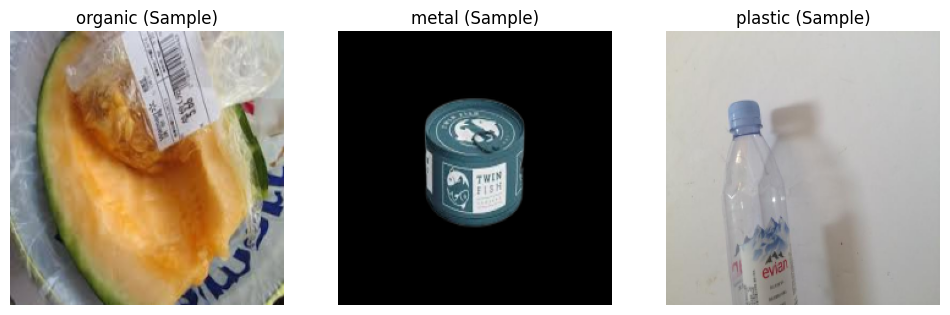

In [7]:
# Task 4: Visualize Sample Images
# Purpose: Verify dataset loading and quality (outcome 2: acquisition technologies).
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
category_names = list(categories.keys())

# Count images per category for balance check
for cat_idx in [0, 1, 2]:
    count = np.sum(labels == cat_idx)
    print(f"Category {category_names[cat_idx]}: {count} images")

for i, cat_idx in enumerate([0, 1, 2]):
    idx = np.where(labels == cat_idx)[0][0]  # First image of category
    # Convert normalized image (float64, [0,1]) back to uint8 (0-255) for cvtColor
    img_uint8 = (images[idx] * 255).astype(np.uint8)
    axs[i].imshow(cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB))  # BGR to RGB
    axs[i].set_title(f"{category_names[cat_idx]} (Sample)")
    axs[i].axis('off')

# Save plot for report
plt.savefig('sample_images.png', bbox_inches='tight')
plt.show()

In [8]:
# Task 5: Build Lightweight CNN Model with Pre-trained Option
# Use MobileNetV2 (pre-trained) for better feature extraction, fine-tuned for 3 classes (outcome 3).
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load pre-trained MobileNetV2, exclude top layers, input shape 224x224x3
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers initially

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replace Flatten for pre-trained compatibility
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(3, activation='softmax')  # 3 classes
])

# Compile with adjusted learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20


/Users/nisila/University/Computer Vision/CW/ComputerVision/env/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.4028 - loss: 1.3449 - val_accuracy: 0.6111 - val_loss: 0.8672
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5167 - loss: 1.0130 - val_accuracy: 0.7556 - val_loss: 0.6736
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6667 - loss: 0.7766 - val_accuracy: 0.7667 - val_loss: 0.5505
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7222 - loss: 0.6331 - val_accuracy: 0.8111 - val_loss: 0.4839
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.7222 - loss: 0.6305 - val_accuracy: 0.8556 - val_loss: 0.4418
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7972 - loss: 0.5533 - val_accuracy: 0.8667 - val_loss: 0.3938
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.7917 - loss: 0.5056 - val_accuracy: 0.8667 - val_loss: 0.3743
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.7972 - loss: 0.4765 - val_accuracy: 0.8778 - val_

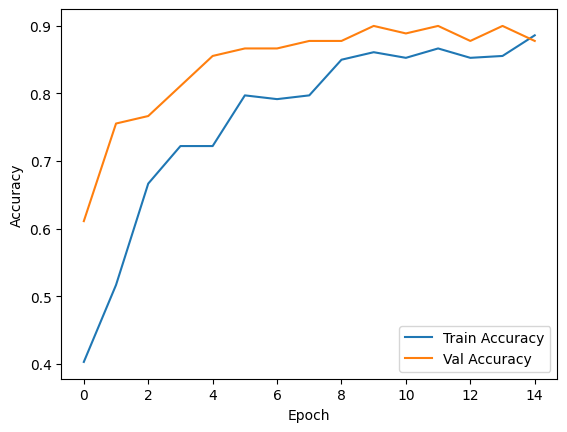

In [9]:
# Task 6: Train the Model
# Train with enhanced augmentation and early stopping to optimize for 85% (outcome 4).
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max', verbose=1)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),  # Reduced batch size for better updates
    epochs=20,  # Increased to allow convergence, early stopping will limit
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_accuracy.png', bbox_inches='tight')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step
              precision    recall  f1-score   support

     organic       1.00      0.94      0.97        35
       metal       0.81      0.91      0.86        23
     plastic       0.87      0.84      0.86        32

    accuracy                           0.90        90
   macro avg       0.89      0.90      0.89        90
weighted avg       0.90      0.90      0.90        90



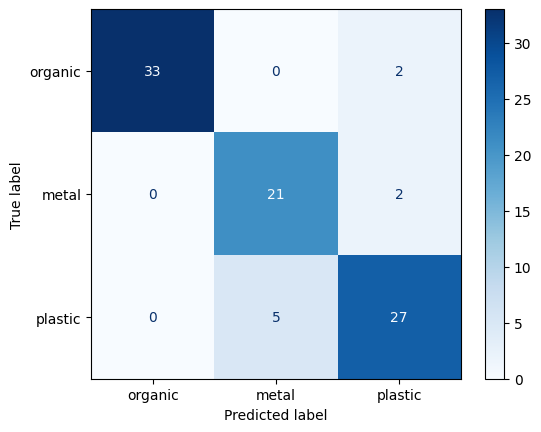

In [10]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics
print(classification_report(y_true, y_pred_classes, target_names=category_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=category_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()